<a href="https://colab.research.google.com/github/buntys2010/AV-AmExpert-2019-ML-Hackathon/blob/master/Amexpert_2019_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Data

In [0]:
from google.colab import files

In [0]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"buntyshah","key":"9f654aca594a996bd14418483b21a6af"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download buntyshah/amexpert-2019

 78% 9.00M/11.5M [00:00<00:00, 16.7MB/s]
100% 11.5M/11.5M [00:00<00:00, 21.4MB/s]


In [0]:
!unzip "../content/amexpert-2019.zip" 

Archive:  ../content/amexpert-2019.zip
  inflating: Submission.csv          
  inflating: test_QyjYwdj.csv        
  inflating: train_AUpWtIz (1)/campaign_data.csv  
  inflating: train_AUpWtIz (1)/coupon_item_mapping.csv  
  inflating: train_AUpWtIz (1)/customer_demographics.csv  
  inflating: train_AUpWtIz (1)/customer_transaction_data.csv  
  inflating: train_AUpWtIz (1)/item_data.csv  
  inflating: train_AUpWtIz (1)/train.csv  


## Read Data

In [0]:
import pandas as pd
import numpy as np
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold

from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Lgbm
import lightgbm as lgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [0]:
train= pd.read_csv("../content/train_AUpWtIz (1)/train.csv")

In [0]:
train.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [0]:
train.shape

(78369, 5)

In [0]:
test = pd.read_csv("../content/test_QyjYwdj.csv")

In [0]:
# Read 5 common files

campaign_data = pd.read_csv("../content/train_AUpWtIz (1)/campaign_data.csv")
coupon_item_mapping =  pd.read_csv("../content/train_AUpWtIz (1)/coupon_item_mapping.csv")
customer_demographics = pd.read_csv("../content/train_AUpWtIz (1)/customer_demographics.csv")
customer_transaction_data = pd.read_csv("../content/train_AUpWtIz (1)/customer_transaction_data.csv")
item_data = pd.read_csv("../content/train_AUpWtIz (1)/item_data.csv")

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/09/Screenshot-2019-09-28-at-8.58.32-PM.png)

## Lets Combine campaign_id with Train/test as it doesnt have any dependency

In [0]:
train_df = pd.merge(train,campaign_data,on='campaign_id',how='left')
test_df = pd.merge(test,campaign_data,on='campaign_id',how='left')

## Lets Combine customer_demographics with train and test

In [0]:
train_df = pd.merge(train_df , customer_demographics ,on='customer_id',how='left')
test_df = pd.merge(test_df , customer_demographics ,on='customer_id',how='left')

## Create new DF to combine remaining blocks

In [0]:
df = pd.merge(customer_transaction_data , item_data ,on='item_id',how='left')
df = pd.merge(df , coupon_item_mapping ,on='item_id',how='left')

In [0]:
df = df.fillna(0)

In [0]:
df['date'] = df['date'].astype('datetime64[ns]') 
#df['C_date_year'] = df['date'].dt.year
df['C_date_month'] = df['date'].dt.month
df['C_date_day'] = df['date'].dt.day
# df = df.drop('date',axis=1)

In [0]:
## Feature engg
df['per_item_price'] = df['selling_price'] / df['quantity']
df['item_price_after_discount'] = (df['selling_price'] + df['other_discount'] + df['coupon_discount']) / df['quantity']
df['discount'] = df['other_discount'] + df['coupon_discount']

In [0]:
df['NF_coupon_month'] = df['coupon_id'].astype(str) + "_" + df['C_date_month'].astype(str)

In [0]:
from sklearn.preprocessing import LabelEncoder
for f in df.columns:
    if  df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

## Creating Aggrigate features for *customer_id*

Note : Created Additional Mode Feature apart from Part 1 Solution

In [0]:
['mean','sum','min','max','median','quantile','mad','std','count','nunique']
ag_cat=['count','nunique','min','max','last']
ag_num=['mean','sum','min','max','median','quantile','mad','std']

agg_func = {     # find the sum of the durations for each group
                                    'item_id' : ag_cat,
                                    'quantity':ag_num,
                                    'selling_price': ag_num,
                                    'other_discount':ag_num,
                                    'coupon_discount':ag_num,
                                    'brand':ag_cat,
                                    'brand_type':ag_cat,
                                    'category':ag_cat,
                                    'coupon_id':ag_cat,
                                    #'C_date_year':ag_cat,
                                    'C_date_month':ag_cat,
                                    'C_date_day':ag_cat,
                                    'per_item_price':ag_num,
                                    'item_price_after_discount':ag_num,
                                    'NF_coupon_month':ag_cat
                                }

In [0]:
df_customer_groupby = df.groupby(by=['customer_id']).agg(agg_func)
df_customer_groupby.columns=['agg_cust_id_' + '_'.join(col).strip() for col in df_customer_groupby.columns.values]
df_customer_groupby.reset_index(inplace=True)
df_customer_groupby.head()

,customer_id,agg_cust_id_item_id_count,agg_cust_id_item_id_nunique,agg_cust_id_item_id_min,agg_cust_id_item_id_max,agg_cust_id_item_id_last,agg_cust_id_quantity_mean,agg_cust_id_quantity_sum,agg_cust_id_quantity_min,agg_cust_id_quantity_max,agg_cust_id_quantity_median,agg_cust_id_quantity_quantile,agg_cust_id_quantity_mad,agg_cust_id_quantity_std,agg_cust_id_selling_price_mean,agg_cust_id_selling_price_sum,agg_cust_id_selling_price_min,agg_cust_id_selling_price_max,agg_cust_id_selling_price_median,agg_cust_id_selling_price_quantile,agg_cust_id_selling_price_mad,agg_cust_id_selling_price_std,agg_cust_id_other_discount_mean,agg_cust_id_other_discount_sum,agg_cust_id_other_discount_min,agg_cust_id_other_discount_max,agg_cust_id_other_discount_median,agg_cust_id_other_discount_quantile,agg_cust_id_other_discount_mad,agg_cust_id_other_discount_std,agg_cust_id_coupon_discount_mean,agg_cust_id_coupon_discount_sum,agg_cust_id_coupon_discount_min,agg_cust_id_coupon_discount_max,agg_cust_id_coupon_discount_median,agg_cust_id_coupon_discount_quantile,agg_cust_id_coupon_discount_mad,agg_cust_id_coupon_discount_std,agg_cust_id_brand_count,agg_cust_id_brand_nunique,...,agg_cust_id_category_nunique,agg_cust_id_category_min,agg_cust_id_category_max,agg_cust_id_category_last,agg_cust_id_coupon_id_count,agg_cust_id_coupon_id_nunique,agg_cust_id_coupon_id_min,agg_cust_id_coupon_id_max,agg_cust_id_coupon_id_last,agg_cust_id_C_date_month_count,agg_cust_id_C_date_month_nunique,agg_cust_id_C_date_month_min,agg_cust_id_C_date_month_max,agg_cust_id_C_date_month_last,agg_cust_id_C_date_day_count,agg_cust_id_C_date_day_nunique,agg_cust_id_C_date_day_min,agg_cust_id_C_date_day_max,agg_cust_id_C_date_day_last,agg_cust_id_per_item_price_mean,agg_cust_id_per_item_price_sum,agg_cust_id_per_item_price_min,agg_cust_id_per_item_price_max,agg_cust_id_per_item_price_median,agg_cust_id_per_item_price_quantile,agg_cust_id_per_item_price_mad,agg_cust_id_per_item_price_std,agg_cust_id_item_price_after_discount_mean,agg_cust_id_item_price_after_discount_sum,agg_cust_id_item_price_after_discount_min,agg_cust_id_item_price_after_discount_max,agg_cust_id_item_price_after_discount_median,agg_cust_id_item_price_after_discount_quantile,agg_cust_id_item_price_after_discount_mad,agg_cust_id_item_price_after_discount_std,agg_cust_id_NF_coupon_month_count,agg_cust_id_NF_coupon_month_nunique,agg_cust_id_NF_coupon_month_min,agg_cust_id_NF_coupon_month_max,agg_cust_id_NF_coupon_month_last
0,1,2211,463,4315,73348,45986,1.134328,2508,1,5,1,1.0,0.240588,0.454791,95.070873,210201.70,12.11,445.25,89.05,89.05,35.683296,53.433822,-20.346404,-44985.90,-372.23,0.0,-10.69,-10.69,21.518545,36.210123,-1.940900,-4291.33,-106.86,0.0,0.0,0.0,3.595625,8.661971,2211,163,...,9,1,13,6,2211,160,0.0,1089.0,30.0,2211,12,1,12,6,2211,28,1,31,30,86.604146,191481.767500,12.110000,391.46,89.05,89.05,31.372843,43.240596,68.600825,151676.423833,-35.265,391.46,63.760,63.760,36.339287,46.937958,2211,725,0,12108,3738
1,2,823,352,137,73242,73242,1.117861,920,1,5,1,1.0,0.213669,0.417919,103.368943,85072.64,14.25,640.80,89.05,89.05,45.778112,71.076889,-16.798141,-13824.87,-312.03,0.0,0.00,0.00,20.244751,33.011891,-0.302965,-249.34,-89.05,0.0,0.0,0.0,0.602985,4.721158,823,153,...,9,1,16,11,823,138,0.0,1109.0,32.0,823,11,2,12,6,823,19,1,28,26,95.445093,78551.311667,7.125000,640.80,88.34,88.34,39.491361,63.636083,81.248777,66867.743500,-78.010,640.80,70.880,70.880,43.799330,67.801977,823,302,1,12220,3982
2,3,1351,406,4308,73698,73698,6.861584,9270,1,6949,1,1.0,10.358366,189.016329,113.680792,153582.75,8.90,862.00,89.05,89.05,59.687796,85.572038,-24.400081,-32964.51,-463.06,0.0,-9.26,-9.26,25.908501,40.760823,-2.578209,-3483.16,-142.48,0.0,0.0,0.0,4.797644,11.568789,1351,114,...,8,4,16,6,1351,136,0.0,1109.0,0.0,1351,12,1,12,6,1351,23,1,31,16,77.733098,105017.415082,0.102570,862.00,70.88,70.88,36.123117,64.565806,60.573072,81834.220831,-70.520,487.63,49.865,49.865,34.352176,52.264127,1351,408,0,12183,8
3,4,451,125,4617,

In [0]:
train_df = pd.merge(train_df , df_customer_groupby ,on='customer_id',how='left')
test_df = pd.merge(test_df , df_customer_groupby ,on='customer_id',how='left')

In [0]:
# Add Mode Values

import scipy.stats
df_customer_groupby_mode = df.groupby(by=['customer_id']).agg(lambda x: scipy.stats.mode(x)[0][0])
df_customer_groupby_mode.columns= ['agg_cust_id_' + col +'_mode' for col in df_customer_groupby_mode.columns.values]
df_customer_groupby_mode.reset_index(inplace=True)
df_customer_groupby_mode.head()

,customer_id,agg_cust_id_date_mode,agg_cust_id_item_id_mode,agg_cust_id_quantity_mode,agg_cust_id_selling_price_mode,agg_cust_id_other_discount_mode,agg_cust_id_coupon_discount_mode,agg_cust_id_brand_mode,agg_cust_id_brand_type_mode,agg_cust_id_category_mode,agg_cust_id_coupon_id_mode,agg_cust_id_C_date_month_mode,agg_cust_id_C_date_day_mode,agg_cust_id_per_item_price_mode,agg_cust_id_item_price_after_discount_mode,agg_cust_id_discount_mode,agg_cust_id_NF_coupon_month_mode
0,1,2012-12-03,45986,1,89.05,0.0,0.0,1075,0,6,0.0,5,3,89.05,106.50,0.0,7
1,2,2012-06-13,30981,1,71.24,0.0,0.0,56,0,6,0.0,6,13,71.24,106.50,0.0,8
2,3,2012-11-16,22883,1,70.88,0.0,0.0,56,0,6,0.0,9,16,35.62,70.88,0.0,9
3,4,2012-07-18,47968,1,89.05,0.0,0.0,56,0,6,0.0,7,18,89.05,71.60,0.0,7
4,5,2012-04-28,35304,1,35.26,0.0,0.0,56,0,6,0.0,5,28,35.26,35.26,0.0,8


In [0]:
train_df = pd.merge(train_df , df_customer_groupby_mode ,on='customer_id',how='left')
test_df = pd.merge(test_df , df_customer_groupby_mode ,on='customer_id',how='left')

## Creating Aggrigate features for coupon_id

Note : Created Additional Mode Feature apart from Part 1 Solution


In [0]:
['mean','sum','min','max','median','quantile','mad','std','count','nunique']
ag_cat=['count','nunique','min','max','last']
ag_num=['mean','sum','min','max','median','quantile','mad','std']

agg_func_1 = {     # find the sum of the durations for each group
                                    'customer_id' : ag_cat,
                                    'quantity':ag_num,
                                    'selling_price': ag_num,
                                    'other_discount':ag_num,
                                    'coupon_discount':ag_num,
                                    'brand':ag_cat,
                                    'brand_type':ag_cat,
                                    'category':ag_cat,
                                    'item_id':ag_cat,
                                    #'C_date_year':ag_cat,
                                    'C_date_month':ag_cat,
                                    'C_date_day':ag_cat,
                                    'per_item_price':ag_num,
                                    'item_price_after_discount':ag_num,
                                    'NF_coupon_month':ag_cat
                                }

In [0]:
df_coupon_id_groupby = df.groupby(by=['coupon_id']).agg(agg_func_1)
df_coupon_id_groupby.columns=['agg_cp_id_' + '_'.join(col).strip() for col in df_coupon_id_groupby.columns.values]
df_coupon_id_groupby.reset_index(inplace=True)
train_df = pd.merge(train_df , df_coupon_id_groupby ,on='coupon_id',how='left')
test_df = pd.merge(test_df , df_coupon_id_groupby ,on='coupon_id',how='left')

In [0]:
# Add Mode Values

import scipy.stats
df_coupon_id_groupby_mode = df.groupby(by=['coupon_id']).agg(lambda x: scipy.stats.mode(x)[0][0])
df_coupon_id_groupby_mode.columns= ['agg_cp_id_' + col +'_mode' for col in df_coupon_id_groupby_mode.columns.values]
df_coupon_id_groupby_mode.reset_index(inplace=True)
df_coupon_id_groupby_mode.head()

,coupon_id,agg_cp_id_date_mode,agg_cp_id_customer_id_mode,agg_cp_id_item_id_mode,agg_cp_id_quantity_mode,agg_cp_id_selling_price_mode,agg_cp_id_other_discount_mode,agg_cp_id_coupon_discount_mode,agg_cp_id_brand_mode,agg_cp_id_brand_type_mode,agg_cp_id_category_mode,agg_cp_id_C_date_month_mode,agg_cp_id_C_date_day_mode,agg_cp_id_per_item_price_mode,agg_cp_id_item_price_after_discount_mode,agg_cp_id_discount_mode,agg_cp_id_NF_coupon_month_mode
0,0.0,2012-09-03,711,49009,1,35.62,0.00,0.0,56,0,6,5,15,35.62,70.88,0.00,7
1,1.0,2013-01-12,435,45529,1,71.24,-35.26,0.0,1475,0,9,5,29,71.24,35.98,-35.26,19
2,2.0,2012-01-17,1466,12901,1,89.05,-21.02,0.0,2084,0,6,4,6,89.05,68.03,-21.02,2523
3,3.0,2012-07-06,1064,59117,1,106.86,0.00,0.0,278,0,6,1,1,106.86,78.72,0.00,3718
4,4.0,2012-11-23,140,51242,1,177.74,-35.62,0.0,544,0,6,6,26,177.74,142.12,-35.62,5017


In [0]:
train_df = pd.merge(train_df , df_coupon_id_groupby_mode ,on='coupon_id',how='left')
test_df = pd.merge(test_df , df_coupon_id_groupby_mode ,on='coupon_id',how='left')

## Aggrigate with customer_id and coupon_id combine

Note : Created Additional Mode Feature apart from Part 1 Solution

In [0]:
['mean','sum','min','max','median','quantile','mad','std','count','nunique']
ag_cat=['count','nunique','min','max','last']
ag_num=['mean','sum','min','max','median','quantile','mad','std']

agg_func_2 = {     # find the sum of the durations for each group
                                   # 'customer_id' : ag_cat,
                                    'quantity':ag_num,
                                    'selling_price': ag_num,
                                   # 'other_discount':ag_num,
                                   # 'coupon_discount':ag_num,
                                    'brand':ag_cat,
                                    'brand_type':ag_cat,
                                    'category':ag_cat,
                                    'item_id':ag_cat,
                                    #'C_date_year':ag_cat,
                                    'C_date_month':ag_cat,
                                    'C_date_day':ag_cat,
                                    #'per_item_price':ag_num,
                                    #'item_price_after_discount':ag_num
                                    'NF_coupon_month':ag_cat
                                }

In [0]:
df_cust_cp_id_groupby = df.groupby(by=['customer_id','coupon_id']).agg(agg_func_2)

In [0]:
df_cust_cp_id_groupby.columns=['agg_cust_cp_id_' + '_'.join(col).strip() for col in df_cust_cp_id_groupby.columns.values]
df_cust_cp_id_groupby.reset_index(inplace=True)
train_df = pd.merge(train_df , df_cust_cp_id_groupby ,on=['customer_id','coupon_id'],how='left')
test_df = pd.merge(test_df , df_cust_cp_id_groupby ,on=['customer_id','coupon_id'],how='left')

In [0]:
# Add Mode Values

import scipy.stats
df_cust_cp_id_groupby_mode = df.groupby(by=['customer_id','coupon_id']).agg(lambda x: scipy.stats.mode(x)[0][0])
df_cust_cp_id_groupby_mode.columns= ['agg_cust_cp_id_' + col +'_mode' for col in df_cust_cp_id_groupby_mode.columns.values]
df_cust_cp_id_groupby_mode.reset_index(inplace=True)
df_cust_cp_id_groupby_mode.head()

,customer_id,coupon_id,agg_cust_cp_id_date_mode,agg_cust_cp_id_item_id_mode,agg_cust_cp_id_quantity_mode,agg_cust_cp_id_selling_price_mode,agg_cust_cp_id_other_discount_mode,agg_cust_cp_id_coupon_discount_mode,agg_cust_cp_id_brand_mode,agg_cust_cp_id_brand_type_mode,agg_cust_cp_id_category_mode,agg_cust_cp_id_C_date_month_mode,agg_cust_cp_id_C_date_day_mode,agg_cust_cp_id_per_item_price_mode,agg_cust_cp_id_item_price_after_discount_mode,agg_cust_cp_id_discount_mode,agg_cust_cp_id_NF_coupon_month_mode
0,1,0.0,2012-08-12,8307,1,106.50,0.00,0.0,141,0,6,5,3,106.50,106.50,0.00,7
1,1,1.0,2012-10-18,59842,1,71.24,-35.26,0.0,1475,0,9,3,12,71.24,35.98,-35.26,13
2,1,6.0,2012-06-19,30818,1,44.52,-19.23,0.0,946,0,6,6,3,44.52,32.41,-19.23,7408
3,1,7.0,2012-06-14,8539,1,89.05,0.00,0.0,1487,0,9,12,18,89.05,71.60,0.00,8644
4,1,8.0,2012-02-21,17047,1,142.12,0.00,0.0,1898,0,10,2,18,89.05,142.12,0.00,9832


In [0]:
train_df = pd.merge(train_df , df_cust_cp_id_groupby_mode ,on=['customer_id','coupon_id'],how='left')
test_df = pd.merge(test_df , df_cust_cp_id_groupby_mode ,on=['customer_id','coupon_id'],how='left')

## Changes in Train and Test DF

Note : Created additional feature to find difference between campaign start date to transaction date

In [0]:
# Creating New Feature of Trasaction date to campain date
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,agg_cust_id_item_id_count,agg_cust_id_item_id_nunique,agg_cust_id_item_id_min,agg_cust_id_item_id_max,agg_cust_id_item_id_last,agg_cust_id_quantity_mean,agg_cust_id_quantity_sum,agg_cust_id_quantity_min,agg_cust_id_quantity_max,agg_cust_id_quantity_median,agg_cust_id_quantity_quantile,agg_cust_id_quantity_mad,agg_cust_id_quantity_std,agg_cust_id_selling_price_mean,agg_cust_id_selling_price_sum,agg_cust_id_selling_price_min,agg_cust_id_selling_price_max,agg_cust_id_selling_price_median,agg_cust_id_selling_price_quantile,agg_cust_id_selling_price_mad,agg_cust_id_selling_price_std,agg_cust_id_other_discount_mean,agg_cust_id_other_discount_sum,agg_cust_id_other_discount_min,agg_cust_id_other_discount_max,agg_cust_id_other_discount_median,...,agg_cust_cp_id_category_count,agg_cust_cp_id_category_nunique,agg_cust_cp_id_category_min,agg_cust_cp_id_category_max,agg_cust_cp_id_category_last,agg_cust_cp_id_item_id_count,agg_cust_cp_id_item_id_nunique,agg_cust_cp_id_item_id_min,agg_cust_cp_id_item_id_max,agg_cust_cp_id_item_id_last,agg_cust_cp_id_C_date_month_count,agg_cust_cp_id_C_date_month_nunique,agg_cust_cp_id_C_date_month_min,agg_cust_cp_id_C_date_month_max,agg_cust_cp_id_C_date_month_last,agg_cust_cp_id_C_date_day_count,agg_cust_cp_id_C_date_day_nunique,agg_cust_cp_id_C_date_day_min,agg_cust_cp_id_C_date_day_max,agg_cust_cp_id_C_date_day_last,agg_cust_cp_id_NF_coupon_month_count,agg_cust_cp_id_NF_coupon_month_nunique,agg_cust_cp_id_NF_coupon_month_min,agg_cust_cp_id_NF_coupon_month_max,agg_cust_cp_id_NF_coupon_month_last,agg_cust_cp_id_date_mode,agg_cust_cp_id_item_id_mode,agg_cust_cp_id_quantity_mode,agg_cust_cp_id_selling_price_mode,agg_cust_cp_id_other_discount_mode,agg_cust_cp_id_coupon_discount_mode,agg_cust_cp_id_brand_mode,agg_cust_cp_id_brand_type_mode,agg_cust_cp_id_category_mode,agg_cust_cp_id_C_date_month_mode,agg_cust_cp_id_C_date_day_mode,agg_cust_cp_id_per_item_price_mode,agg_cust_cp_id_item_price_after_discount_mode,agg_cust_cp_id_discount_mode,agg_cust_cp_id_NF_coupon_month_mode
0,1,13,27,1053,0,X,19/05/13,05/07/13,46-55,NaN,0.0,1,NaN,5.0,610,208,4308,73371,49009,173.785246,106009,1,12444,1,1.0,336.017119,1159.978943,165.690918,101071.46,17.45,5164.54,71.24,71.24,143.999325,368.818706,-37.773820,-23042.03,-890.50,0.0,-10.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,13,116,48,0,X,19/05/13,05/07/13,36-45,Married,0.0,2,NaN,3.0,846,244,4525,71973,64341,15.053191,12735,1,11586,1,1.0,27.354484,398.289120,165.157400,139723.16,7.12,1758.92,89.05,89.05,133.840650,281.595271,-28.870816,-24424.71,-372.23,0.0,-10.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,9,635,205,0,Y,11/03/13,12/04/13,46-55,Married,0.0,2,NaN,7.0,2016,533,4368,73695,30289,1.426091,2875,1,10,1,1.0,0.634910,1.021600,120.835823,243605.02,17.45,1056.13,99.38,99.38,61.183193,100.879205,-19.046171,-38397.08,-468.05,0.0,-3.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,13,644,1050,0,X,19/05/13,05/07/13,NaN,NaN,NaN,NaN,NaN,NaN,454,216,4740,71849,29771,1.325991,602,1,5,1,1.0,0.515554,0.748440,98.992401,44942.55,13.89,708.48,71.24,71.24,62.803231,96.414604,-18.019978,-8181.07,-312.03,0.0,-7.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,X,16/02/13,05/04/13,46-55,Married,0.0,2,NaN,3.0,1000,327,4308,73135,46442,139.702000,139702,1,15420,1,1.0,272.294344,1241.859979,111.164700,111164.70,8.90,1424.80,71.24

In [0]:
train_df['start_date'] = pd.to_datetime(train_df['start_date'])
test_df['start_date'] = pd.to_datetime(test_df['start_date'])

train_df['end_date'] = pd.to_datetime(train_df['end_date'])
test_df['end_date'] = pd.to_datetime(test_df['end_date'])

In [0]:
train_df['agg_cust_id_date_mode'] = pd.to_datetime(train_df['agg_cust_id_date_mode'])
train_df['agg_cust_cp_id_date_mode'] = pd.to_datetime(train_df['agg_cust_cp_id_date_mode'])
train_df['agg_cp_id_date_mode'] = pd.to_datetime(train_df['agg_cp_id_date_mode'])

test_df['agg_cust_id_date_mode'] = pd.to_datetime(test_df['agg_cust_id_date_mode'])
test_df['agg_cust_cp_id_date_mode'] = pd.to_datetime(test_df['agg_cust_cp_id_date_mode'])
test_df['agg_cp_id_date_mode'] = pd.to_datetime(test_df['agg_cp_id_date_mode'])

In [0]:
#train_df['start_date_year'] = train_df['start_date'].dt.year
train_df['start_date_month'] = train_df['start_date'].dt.month
train_df['start_date_day'] = train_df['start_date'].dt.day

#test_df['start_date_year'] = test_df['start_date'].dt.year
test_df['start_date_month'] = test_df['start_date'].dt.month
test_df['start_date_day'] = test_df['start_date'].dt.day

In [0]:
#train_df['end_date_year'] = train_df['end_date'].dt.year
train_df['end_date_month'] = train_df['end_date'].dt.month
train_df['end_date_day'] = train_df['end_date'].dt.day

#test_df['end_date_year'] = test_df['end_date'].dt.year
test_df['end_date_month'] = test_df['end_date'].dt.month
test_df['end_date_day'] = test_df['end_date'].dt.day

In [0]:
train_df['agg_cust_id_date_mode_month'] = train_df['agg_cust_id_date_mode'].dt.month
train_df['agg_cust_cp_id_date_mode_month'] = train_df['agg_cust_cp_id_date_mode'].dt.month
train_df['agg_cp_id_date_mode_month'] = train_df['agg_cp_id_date_mode'].dt.month

train_df['agg_cust_id_date_mode_day'] = train_df['agg_cust_id_date_mode'].dt.day
train_df['agg_cust_cp_id_date_mode_day'] = train_df['agg_cust_cp_id_date_mode'].dt.day
train_df['agg_cp_id_date_mode_day'] = train_df['agg_cp_id_date_mode'].dt.day

test_df['agg_cust_id_date_mode_month'] = test_df['agg_cust_id_date_mode'].dt.month
test_df['agg_cust_cp_id_date_mode_month'] = test_df['agg_cust_cp_id_date_mode'].dt.month
test_df['agg_cp_id_date_mode_month'] = test_df['agg_cp_id_date_mode'].dt.month

test_df['agg_cust_id_date_mode_day'] = test_df['agg_cust_id_date_mode'].dt.day
test_df['agg_cust_cp_id_date_mode_day'] = test_df['agg_cust_cp_id_date_mode'].dt.day
test_df['agg_cp_id_date_mode_day'] = test_df['agg_cp_id_date_mode'].dt.day

In [0]:
train_df['agg_cust_id_date_mode_diff'] = (train_df['agg_cust_id_date_mode']  - train_df['start_date'])/np.timedelta64(1,'D')
train_df['agg_cust_cp_id_date_mode_diff'] = (train_df['agg_cust_cp_id_date_mode']  - train_df['start_date'])/np.timedelta64(1,'D')
train_df['agg_cp_id_date_mode_diff'] = (train_df['agg_cp_id_date_mode']  - train_df['start_date'])/np.timedelta64(1,'D')

test_df['agg_cust_id_date_mode_diff'] = (test_df['agg_cust_id_date_mode']  - test_df['start_date'])/np.timedelta64(1,'D')
test_df['agg_cust_cp_id_date_mode_diff'] = (test_df['agg_cust_cp_id_date_mode']  - test_df['start_date'])/np.timedelta64(1,'D')
test_df['agg_cp_id_date_mode_diff'] = (test_df['agg_cp_id_date_mode']  - test_df['start_date'])/np.timedelta64(1,'D')

In [0]:
train_df['campaign_run'] = (train_df['end_date']  - train_df['start_date'])/np.timedelta64(1,'D')
test_df['campaign_run'] = (test_df['end_date']  - test_df['start_date'])/ np.timedelta64(1,'D')

In [0]:
train_df = train_df.drop(['start_date','end_date','no_of_children','id','agg_cust_cp_id_date_mode'],axis=1)
test_df = test_df.drop(['start_date','end_date','no_of_children','id','agg_cust_cp_id_date_mode'],axis=1)

In [0]:
for f in train_df.columns:
    if  train_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))

In [0]:
for f in test_df.columns:
    if  test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [0]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
# Missing values statistics of Customers
missing_values = missing_values_table(train_df)
missing_values.head(10)

Your selected dataframe has 259 columns.
There are 76 columns that have missing values.


,Missing Values,% of Total Values
agg_cust_cp_id_selling_price_std,69506,88.7
agg_cust_cp_id_quantity_std,69506,88.7
agg_cust_cp_id_category_last,64489,82.3
agg_cust_cp_id_NF_coupon_month_max,64489,82.3
agg_cust_cp_id_NF_coupon_month_nunique,64489,82.3
agg_cust_cp_id_NF_coupon_month_count,64489,82.3
agg_cust_cp_id_C_date_day_last,64489,82.3
agg_cust_cp_id_C_date_day_max,64489,82.3
agg_cust_cp_id_C_date_day_min,64489,82.3
agg_cust_cp_id_C_date_day_nunique,64489,82.3


In [0]:
# Missing values statistics of Customers
missing_values = missing_values_table(test_df)
missing_values.head(10)

Your selected dataframe has 258 columns.
There are 76 columns that have missing values.


,Missing Values,% of Total Values
agg_cust_cp_id_selling_price_std,41686,83.0
agg_cust_cp_id_quantity_std,41686,83.0
agg_cust_cp_id_category_last,37305,74.3
agg_cust_cp_id_NF_coupon_month_max,37305,74.3
agg_cust_cp_id_NF_coupon_month_nunique,37305,74.3
agg_cust_cp_id_NF_coupon_month_count,37305,74.3
agg_cust_cp_id_C_date_day_last,37305,74.3
agg_cust_cp_id_C_date_day_max,37305,74.3
agg_cust_cp_id_C_date_day_min,37305,74.3
agg_cust_cp_id_C_date_day_nunique,37305,74.3


## Lets Make aggrigate features for campain ID

In [0]:
target = train_df['redemption_status']
train_df=train_df.drop('redemption_status',axis=1)

In [0]:
frames = [train_df,test_df]

In [0]:
all_df = pd.concat(frames,join='inner',ignore_index=True)

In [0]:
all_df.shape

(128595, 258)

In [0]:
['mean','sum','min','max','median','quantile','mad','std','count','nunique']
ag_cat=['sum', 'mean','count','nunique','min','max']
ag_num=['mean','sum','min','max','median','quantile','mad','std']
agg_func4 = {
    'coupon_id':ag_cat,
'customer_id':ag_cat,
'campaign_type':ag_cat,
'start_date_month':ag_cat,
'start_date_day':ag_cat,
'campaign_run':ag_num,
'age_range':ag_cat,
'marital_status':ag_cat,
'rented':ag_cat,
'family_size':ag_cat,
#'no_of_children':ag_cat,
'income_bracket':ag_cat
    }

In [0]:
campaign_id_groupby = all_df.groupby(by=['campaign_id']).agg(agg_func4)

In [0]:
campaign_id_groupby.columns=['agg_campaign_id' + '_'.join(col).strip() for col in campaign_id_groupby.columns.values]
campaign_id_groupby.reset_index(inplace=True)
campaign_id_groupby.head()

,campaign_id,agg_campaign_idcoupon_id_sum,agg_campaign_idcoupon_id_mean,agg_campaign_idcoupon_id_count,agg_campaign_idcoupon_id_nunique,agg_campaign_idcoupon_id_min,agg_campaign_idcoupon_id_max,agg_campaign_idcustomer_id_sum,agg_campaign_idcustomer_id_mean,agg_campaign_idcustomer_id_count,agg_campaign_idcustomer_id_nunique,agg_campaign_idcustomer_id_min,agg_campaign_idcustomer_id_max,agg_campaign_idcampaign_type_sum,agg_campaign_idcampaign_type_mean,agg_campaign_idcampaign_type_count,agg_campaign_idcampaign_type_nunique,agg_campaign_idcampaign_type_min,agg_campaign_idcampaign_type_max,agg_campaign_idstart_date_month_sum,agg_campaign_idstart_date_month_mean,agg_campaign_idstart_date_month_count,agg_campaign_idstart_date_month_nunique,agg_campaign_idstart_date_month_min,agg_campaign_idstart_date_month_max,agg_campaign_idstart_date_day_sum,agg_campaign_idstart_date_day_mean,agg_campaign_idstart_date_day_count,agg_campaign_idstart_date_day_nunique,agg_campaign_idstart_date_day_min,agg_campaign_idstart_date_day_max,agg_campaign_idcampaign_run_mean,agg_campaign_idcampaign_run_sum,agg_campaign_idcampaign_run_min,agg_campaign_idcampaign_run_max,agg_campaign_idcampaign_run_median,agg_campaign_idcampaign_run_quantile,agg_campaign_idcampaign_run_mad,agg_campaign_idcampaign_run_std,agg_campaign_idage_range_sum,agg_campaign_idage_range_mean,agg_campaign_idage_range_count,agg_campaign_idage_range_nunique,agg_campaign_idage_range_min,agg_campaign_idage_range_max,agg_campaign_idmarital_status_sum,agg_campaign_idmarital_status_mean,agg_campaign_idmarital_status_count,agg_campaign_idmarital_status_nunique,agg_campaign_idmarital_status_min,agg_campaign_idmarital_status_max,agg_campaign_idrented_sum,agg_campaign_idrented_mean,agg_campaign_idrented_count,agg_campaign_idrented_nunique,agg_campaign_idrented_min,agg_campaign_idrented_max,agg_campaign_idfamily_size_sum,agg_campaign_idfamily_size_mean,agg_campaign_idfamily_size_count,agg_campaign_idfamily_size_nunique,agg_campaign_idfamily_size_min,agg_campaign_idfamily_size_max,agg_campaign_idincome_bracket_sum,agg_campaign_idincome_bracket_mean,agg_campaign_idincome_bracket_count,agg_campaign_idincome_bracket_nunique,agg_campaign_idincome_bracket_min,agg_campaign_idincome_bracket_max
0,1,97448,681.454545,143,11,312,1112,69432,485.538462,143,13,46,1387,143,1,143,1,1,1,1716,12,143,1,12,12,1716,12,143,1,12,12,37.0,5291.0,37.0,37.0,37.0,37.0,0.0,0.0,561,3.923077,143,5,0,6,253,1.769231,143,3,0,2,0.0,0.000000,66,1,0.0,0.0,440,3.076923,143,4,0,5,165.0,2.500000,66,4,1.0,6.0
1,2,564528,735.062500,768,16,347,1107,580160,755.416667,768,48,10,1555,768,1,768,1,1,1,9216,12,768,1,12,12,13056,17,768,1,17,17,32.0,24576.0,32.0,32.0,32.0,32.0,0.0,0.0,3600,4.687500,768,6,0,6,1232,1.604167,768,3,0,2,112.0,0.368421,304,2,0.0,1.0,2608,3.395833,768,5,0,5,1328.0,4.368421,304,8,1.0,12.0
2,3,255624,626.529412,408,34,263,864,342312,839.000000,408,12,67,1534,408,1,408,1,1,1,4896,12,408,1,12,12,8976,22,408,1,22,22,56.0,22848.0,56.0,56.0,56.0,56.0,0.0,0.0,1530,3.750000,408,5,2,6,578,1.416667,408,3,0,2,34.0,0.111111,306,2,0.0,1.0,918,2.250000,408,5,0,5,1020.0,3.333333,306,5,1.0,5.0
3,4,572103,588.583333,972,12,16,935,725124,746.012346,972,81,7,1574,972,1,972,1,1,1,6804,7,972,1,7,7,972,1,972,1,1,1,32.0,31104.0,32.0,32.0,32.0,32.0,0.0,0.0,3480,3.580247,972,7,0,6,1152,1.185185,972,3,0,2,12.0,0.018182,660,2,0.0,1.0,2400,2.469136,972,6,0,5,3552.0,5.381818,660,10,1.0,12.0
4,5,1397413,764.867542,1827,11,279,1105,1610410,881.450465,1827,166,7,1574,1827,1,1827,1,1,1,21924,12,1827,1,12,12,1827,1,1827,1,1,1,-289.0,-528003.0,-289.0,-289.0,-289.0,-289.0,0.0,0.0,6657,3.643678,1827,7,0,6,2630,1.439518,1827,3,0,2,99.0,0.089029,1112,2,0.0,1.0,5292,2.896552,1827,6,0,5,5427.0,4.880396,1112,10,1.0,10.0


In [0]:
train_df = pd.merge(train_df, campaign_id_groupby, on='campaign_id',how='left')
test_df = pd.merge(test_df, campaign_id_groupby, on='campaign_id',how='left')

In [0]:
train_df['redemption_status'] = target

## Apply LGB

Note : LGB and CatBooster didnt provided good result on LB but those score had 92.76 AUC on Private LB

In [0]:
# Align train and test
train_labels = train_df['redemption_status']

# Align the training and testing data, keep only columns present in both dataframes
train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)

# Add the target back in
train_df['redemption_status'] = train_labels

print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (78369, 327)
Testing Features shape:  (50226, 326)


In [0]:
y = train_df['redemption_status']
X = train_df.drop('redemption_status',axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y.values,random_state=10)

## LGB

In [0]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [0]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "binary",
       "n_estimators":10000,
        "learning_rate" :0.007,
        "num_leaves" :90,
        "min_data_in_leaf":3,
        'max_bin':200,
        'max_depth':3,
        "metric" : "auc",
        "reg_alpha" :3,
        "reg_lambda":5,
        'feature_fraction':0.8999999999999121,
        'min_gain_to_split':0.2,
        'bagging_fraction':0.8999999999997461,
        'bagging_freq':50,
        #'scale_pos_weight':15.0
        
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=50, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, test_df)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994399	valid_1's auc: 0.994245
[100]	training's auc: 0.995106	valid_1's auc: 0.994934
[150]	training's auc: 0.996243	valid_1's auc: 0.995222
[200]	training's auc: 0.996484	valid_1's auc: 0.99547
[250]	training's auc: 0.996724	valid_1's auc: 0.995766
[300]	training's auc: 0.997028	valid_1's auc: 0.996007
[350]	training's auc: 0.997262	valid_1's auc: 0.996277
[400]	training's auc: 0.997457	valid_1's auc: 0.996518
[450]	training's auc: 0.997624	valid_1's auc: 0.996718
[500]	training's auc: 0.997725	valid_1's auc: 0.996769
[550]	training's auc: 0.99784	valid_1's auc: 0.996906
[600]	training's auc: 0.997937	valid_1's auc: 0.997026
[650]	training's auc: 0.998077	valid_1's auc: 0.997142
[700]	training's auc: 0.998199	valid_1's auc: 0.997266
[750]	training's auc: 0.998309	valid_1's auc: 0.997399
[800]	training's auc: 0.998391	valid_1's auc: 0.997498
[850]	training's auc: 0.998468	valid_1's auc: 0.997524
[900]	

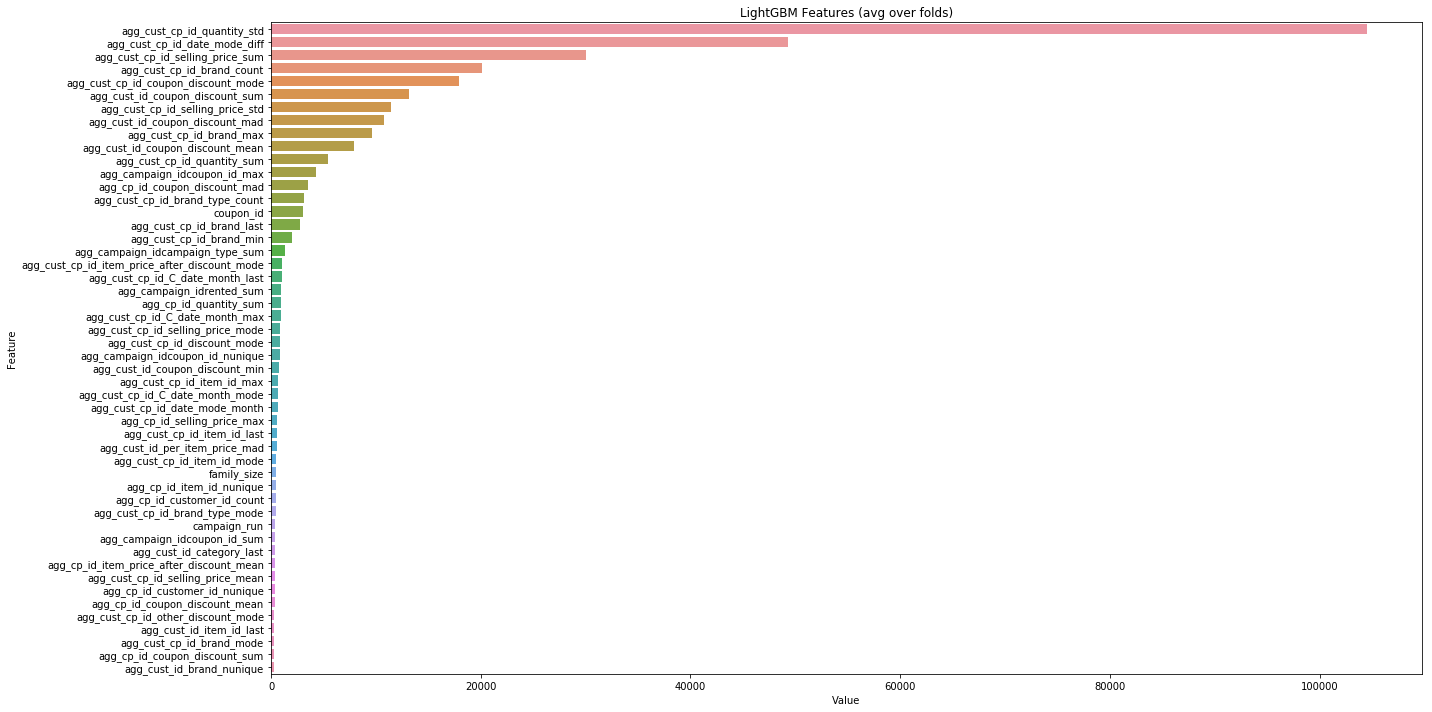

In [0]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Feature'])
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [0]:
sub = pd.read_csv('../content/Submission.csv')

In [0]:
sub['redemption_status'] = pred_test

In [0]:
sub.to_csv('LGB_Mode_Sub7.csv',index=False)

## Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test,y_pred.round())

array([[19397,    13],
       [   60,   122]])

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19410
           1       0.90      0.67      0.77       182

    accuracy                           1.00     19592
   macro avg       0.95      0.83      0.88     19592
weighted avg       1.00      1.00      1.00     19592



## Kfold

In [0]:
params = {
        "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 2.0,
       "reg_lambda":2.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":0.9,
       "subsample":0.8715623,
       "min_data_in_leaf":5,
       "nthread":4,
       "metric" : "auc",
       "num_leaves" : 50,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":150,
       'max_depth':3,
       #'min_gain_to_split':.0222415,
      # 'scale_pos_weight':1
    }

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=4,shuffle=True,random_state=1994)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100)
    preds = model.predict(X_test, num_iteration=model.best_iteration)
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = model.predict(test_df, num_iteration=model.best_iteration)
    y_pred_totcb.append(p)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.996357	valid_1's auc: 0.995476
[200]	training's auc: 0.997127	valid_1's auc: 0.996122
[300]	training's auc: 0.997761	valid_1's auc: 0.99673
[400]	training's auc: 0.998193	valid_1's auc: 0.997028
[500]	training's auc: 0.998492	valid_1's auc: 0.997201
[600]	training's auc: 0.998729	valid_1's auc: 0.997293
[700]	training's auc: 0.998919	valid_1's auc: 0.997343
[800]	training's auc: 0.99908	valid_1's auc: 0.997384
[900]	training's auc: 0.999213	valid_1's auc: 0.997423
[1000]	training's auc: 0.999329	valid_1's auc: 0.997426
Early stopping, best iteration is:
[975]	training's auc: 0.999302	valid_1's auc: 0.997431
err:  0.9974310464720174
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.996376	valid_1's auc: 0.995257
[200]	training's auc: 0.997127	valid_1's auc: 0.995841
[300]	training's auc: 0.997769	valid_1's auc: 0.996356
[400]	training's auc: 0.998165	valid_1's auc:

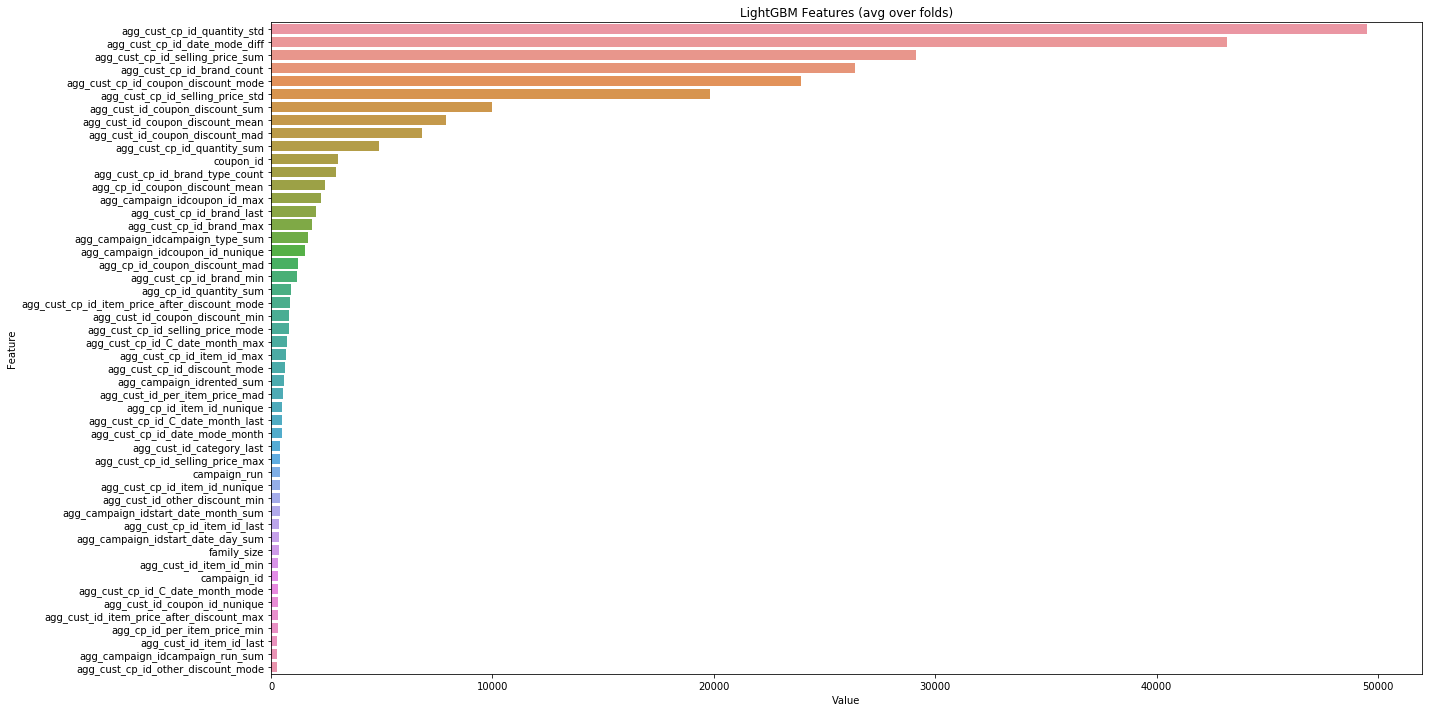

In [0]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Feature'])
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [0]:
y_pred_totcb

[array([1.52934598e-01, 2.08471872e-02, 2.72206833e-05, ...,
        4.59152474e-02, 4.76528554e-02, 1.84901818e-05]),
 array([1.29535227e-01, 7.80923266e-03, 8.19167532e-06, ...,
        1.82690339e-02, 1.05686701e-02, 5.83375482e-06]),
 array([5.47200901e-02, 6.16006247e-03, 3.14403845e-06, ...,
        1.19049884e-02, 2.21174590e-02, 1.86537195e-06]),
 array([1.16461252e-01, 6.89779350e-03, 5.02105588e-06, ...,
        8.60839950e-03, 5.06512839e-02, 4.67432324e-06])]

In [0]:
y_pred = np.mean(y_pred_totcb,0)

In [0]:
sub['redemption_status']= y_pred

In [0]:
sub.to_csv("LGB_Mode_Kfold_Sub4.csv",index=False)

## XGB

In [0]:
import xgboost as xgb

In [0]:
def run_xgb(X_train, X_test, y_train, y_test, test_df_lgb):
    params = {'objective': 'binary:logistic', 
              'booster' : "gbtree",
              'eval_metric':'auc',
              'eta': 0.04,
              'max_depth': 4, 
              'subsample': 0.9500000000000001, #changed from 0.6
              'colsample_bytree': 0.65,
              'lambda':0.3,
              'gamma':0.6,
              'max_delta_step':1,
              'min_child_weight':1.0,
              #'alpha':0.001,
              'random_state': 42,
              #'scale_pos_weight':106,
              'max_bin':300, #changed from 450
              'silent': True}
    
    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_test, y_test)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 1000, watchlist, maximize=False, early_stopping_rounds = 10, verbose_eval=10)
    
    #cv = xgb.cv(params, tr_data, 271, nfold=5, early_stopping_rounds=10, verbose_eval=10)
    
    dtest = xgb.DMatrix(test_df_lgb)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [0]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(X_train, X_test, y_train, y_test, test_df)
print("XGB Training Completed...")

[0]	train-auc:0.657651	valid-auc:0.612099
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.704425	valid-auc:0.674675
[20]	train-auc:0.941264	valid-auc:0.91409
[30]	train-auc:0.983786	valid-auc:0.968966
[40]	train-auc:0.996539	valid-auc:0.987757
[50]	train-auc:0.996624	valid-auc:0.992916
[60]	train-auc:0.996865	valid-auc:0.996216
[70]	train-auc:0.997075	valid-auc:0.99655
[80]	train-auc:0.997194	valid-auc:0.996768
[90]	train-auc:0.998131	valid-auc:0.996968
[100]	train-auc:0.998279	valid-auc:0.997145
[110]	train-auc:0.998376	valid-auc:0.997263
[120]	train-auc:0.998528	valid-auc:0.997365
[130]	train-auc:0.998646	valid-auc:0.99744
[140]	train-auc:0.998759	valid-auc:0.997492
[150]	train-auc:0.99887	valid-auc:0.99753
[160]	train-auc:0.998972	valid-auc:0.997575
[170]	train-auc:0.999061	valid-auc:0.997649
[180]	train-auc:0.999138	valid-auc:0.997688
[190]	train-auc:0.999209	valid-auc:0.

In [0]:
sub['redemption_status'] = pred_test_xgb

In [0]:
sub.to_csv('XGB_Mode_Sub4.csv',index=False)